In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
from networkx.classes.function import get_edge_attributes
from IPython.display import Image
import random
from random_graph import RandomGraphBuilder

from bellman import NegativeCycleException

In [ ]:
def bellman_ford(g, source):
    """
    Computes all the shortest paths in a directed weighted graph with negative edge weights
    (but not negative cycles) between every node and some source node s.
    :param g: the graph to perform the algorithm on
    :param source: the source node to query in g
    :return: None if a negative cycle exists. Otherwise returns a pair of dictionaries containing (1) the distances of each node from source (2) the predecessors of each node u in the shortest path from source to u.
    """

    n = g.number_of_nodes()
    edges = g.edges

    all_weights = get_edge_attributes(g, 'weight').values()
    max_weight = max(all_weights)
    inf = sum(map(abs, all_weights)) + max_weight

    yield max_weight

    distance = {v: inf * 2 for v in g.nodes}
    predecessor = {v: None for v in g.nodes}

    distance[source] = 0

    yield distance.copy(), predecessor.copy()

    for _ in range(n - 1):
        for (u, v) in edges:
            w = edges[u, v]['weight']
            relax = distance[u] + w
            if relax <= max_weight and relax < distance[v]:
                distance[v] = distance[u] + w
                predecessor[v] = u
                
                yield distance.copy(), predecessor.copy()

    for (u, v) in edges:
        w = edges[u, v]['weight']
        if distance[u] + w < distance[v]:
           yield NegativeCycleException(u, v, predecessor)

In [3]:
def update_anim(frame, graph, inf, pos, ax):
    ax.clear()

    # Draw the full graph in grey with edge weights
    nx.draw(graph, pos, ax=ax, node_color='lightgrey', edge_color='lightgrey', with_labels=False)
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, ax=ax, font_color='grey')

    if isinstance(frame, NegativeCycleException):
        nx.draw_networkx_nodes(graph, pos, ax=ax, node_color='red')
        return

    dist, pred = frame

    # Put distance from source as node labels
    label = lambda n: 'inf' if dist[n] > inf else dist[n]
    node_labels = {node: label(node) for node in graph.nodes}
    nx.draw_networkx_labels(graph, pos ,labels=node_labels, ax=ax, font_color='black')

    # Find edges on all shortest paths
    edges = [(pred[v], v) for v in graph.nodes if pred[v] is not None]
    nx.draw_networkx_edges(graph, pos, edgelist=edges, ax=ax, edge_color='red', style='dashed')
    
    edge_labels = {edge: graph.edges[edge]['weight'] for edge in edges}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, ax=ax, font_color='red')




KeyError: None

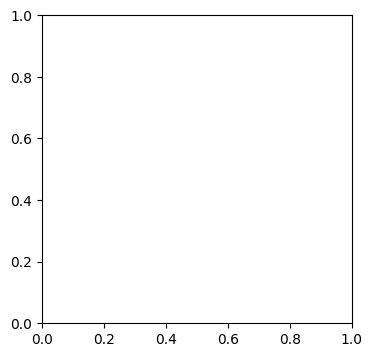

In [4]:
G = RandomGraphBuilder(True).nodes(7).strongly_connected().random_edges(.15).weighted(range(-1, 11)).build()

fig, ax = plt.subplots(figsize=(4, 4))

start = random.choice(list(G.nodes))
pos = nx.bfs_layout(G, start)

bellman_gen = bellman_ford(G, start)

inf = next(bellman_gen)

thing = list(bellman_gen)

FuncAnimation(fig, update_anim, frames=thing, fargs=(G, inf, pos, ax), interval=1000, repeat=False).save("bford_animation.gif", writer='pillow', fps=0.5)

Image(filename="bford_animation.gif")
